In [1]:
import re

import numpy as np
from scipy.ndimage import gaussian_filter
from spectrum.correlation import xcorr


import pandas as pd

import matplotlib.pyplot as plt

import os

from tifffile import TiffFile
import ipywidgets as widgets
from IPython.display import display, clear_output

import steerable

from skimage.morphology import disk, white_tophat
from skimage.transform import resize

Number of slices: 19.0
Number of channels: 4
Pixel size: 0.08302658469728715 µm
Image size: 6540 x 1946 pixels


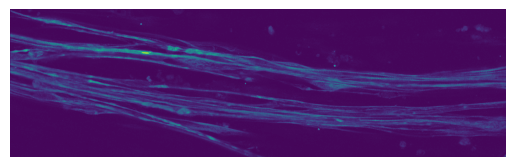

IntSlider(value=0, description='channel index', max=3)

In [2]:
# Define the file path
input_figures_directory = 'Data/'
fly1_image_name = '2023.06.12_MhcGFPweeP26_24hrsAPF_Phallo568_647nano62actn_405nano2sls_100Xz2.5_1_2.tif'
fly2_image_name = '2023.06.12_MhcGFPweeP26_30hrsAPF_Phallo568_647nano62actn_405nano2sls_100Xz2.5_1_2.tif'
human_image_name = 'Trial8_D12_488-TTNrb+633-MHCall_DAPI+568-Rhod_100X_01_stitched.tif'
image_filename = human_image_name

raw_path = os.path.join(input_figures_directory, image_filename)

# Open the image
tif = TiffFile(raw_path)

# Get the number of frames
n = len(tif.pages)
num_channels = 4
num_slices = n/num_channels

# Create slider for frame selection
if num_slices >1:
    slice_widget = widgets.IntSlider(min=0, max=num_slices-1, step=1, value=0, description='slice index')
channel_widget = widgets.IntSlider(min=0, max=num_channels-1, step=1, value=0, description='channel index')

# Define the function to display the selected frame
def display_frame(channel_index, slice_index=0):
    clear_output(wait=True)
    # Select the frame
    raw = np.asarray(tif.pages[channel_index+slice_index].asarray())

    # Get the metadata
    info = tif.pages[channel_index+slice_index].tags
    
    # Get the image factor
    factor = info['XResolution'].value[0]  # The XResolution tag is a ratio, so we take the numerator
    pixSize = 1 / factor *10**(6)  # Factor to go from pixels to micrometers

    # Get Image size
    nY, nX = raw.shape

    print('Number of slices: ' + str(num_slices))
    print('Number of channels: ' + str(num_channels))
    print('Pixel size: ' + str(pixSize) + ' µm')
    print('Image size: ' + str(nX) + ' x ' + str(nY) + ' pixels')
    

    # Display the image
    fig, ax = plt.subplots()
    ax.imshow(raw)
    ax.axis('off')  # Remove axis
    plt.show()
    
    # Display the widget
    display(channel_widget)
    if 'slice_widget' in locals():
        display(slice_widget)

# Call the function to display the initial frame
if 'slice_widget' in locals():
    display_frame(channel_widget.value,slice_widget.value)
else:
    display_frame(channel_widget.value)

# Define the function to update the displayed frame
def update_channel(change):
    display_frame(change.new, slice_widget.value if 'slice_widget' in locals() else 0)

def update_slice(change):
    display_frame(channel_widget.value, change.new)

# Connect the widget to the update function
channel_widget.observe(update_channel, 'value')
if 'slice_widget' in locals():
    slice_widget.observe(update_slice, 'value')

In [3]:
from stardist.models import StarDist2D

# prints a list of available models
StarDist2D.from_pretrained()

# creates a pretrained model
model = StarDist2D.from_pretrained('2D_versatile_fluo')

2023-12-24 22:31:21.617490: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-24 22:31:22.366394: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-24 22:31:22.366601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-24 22:31:22.485668: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-24 22:31:22.716675: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-24 22:31:22.718243: I tensorflow/core/platform/cpu_feature_guard.cc:1

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


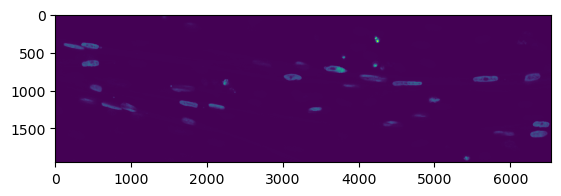

In [4]:
img = np.asarray(tif.pages[2+9*4].asarray())
plt.imshow(img)

2023-12-24 22:31:56.852507: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1635057664 exceeds 10% of free system memory.
2023-12-24 22:31:58.882985: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1635057664 exceeds 10% of free system memory.
2023-12-24 22:32:04.718066: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 408764416 exceeds 10% of free system memory.
2023-12-24 22:32:06.515656: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 408764416 exceeds 10% of free system memory.
2023-12-24 22:32:07.911434: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 408764416 exceeds 10% of free system memory.


Text(0.5, 1.0, 'prediction + input overlay')

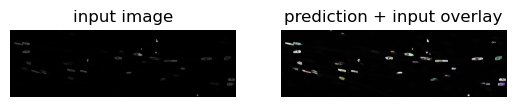

In [5]:
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize
import matplotlib.pyplot as plt

img = np.asarray(tif.pages[2+9*4].asarray())#test_image_nuclei_2d()

labels, details = model.predict_instances(normalize(img))

plt.subplot(1,2,1)
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.title("input image")

plt.subplot(1,2,2)
plt.imshow(render_label(labels, img=img))
plt.axis("off")
plt.title("prediction + input overlay")

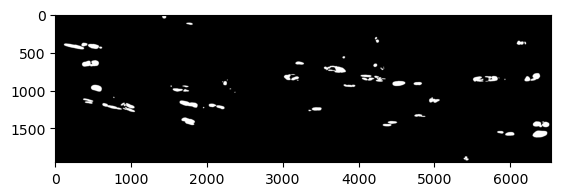

In [10]:
binary_mask = (labels > 0).astype(int)
plt.imshow(binary_mask, cmap='gray')